<a href="https://colab.research.google.com/github/carolinaenriqz/Optimization-Algorithms-for-Uncertain-Knapsack-Problem/blob/main/20250831_experimentos_computacionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## cargar datos de github e importar librerias

In [1]:
!pip -q install XlsxWriter
!pip install mip

!git clone --depth 1 https://github.com/likr/kplib.git

import os
import pandas as pd
from IPython.display import display
from google.colab import files

BASE_DIR = "/content/kplib/00Uncorrelated"
n_values = ["n00050", "n00100", "n00200", "n00500"]
tipo_instancia = "R01000"

instancias = []
for n in n_values:
    ruta = os.path.join(BASE_DIR, n, tipo_instancia)
    if not os.path.isdir(ruta):
        print(f"Ruta no encontrada: {ruta}")
        continue

    archivos = sorted([f for f in os.listdir(ruta) if f.lower().endswith('.kp')])[:60]

    for archivo in archivos:
        ruta_archivo = os.path.join(ruta, archivo)
        try:
            with open(ruta_archivo, 'r') as f:
                lineas = f.readlines()

            num_items = int(lineas[1].strip())
            capacidad = int(lineas[2].strip())
            items = [tuple(map(int, linea.strip().split()))
                     for linea in lineas[4:] if linea.strip()]

            if len(items) != num_items:
                print(f"Advertencia: en {archivo} se esperaban {num_items} ítems pero se leyeron {len(items)}")
                continue

            valores, pesos = zip(*items)
            instancias.append({
                "n": num_items,
                "Capacidad": capacidad,
                "Utilidades": list(valores),
                "Pesos": list(pesos),
                "Archivo": archivo
            })
        except Exception as e:
            print(f"Error al leer {archivo}: {e}")

df_kplib = pd.DataFrame(instancias)
print(f"Instancias cargadas: {df_kplib.shape}")
df_kplib = df_kplib[["Archivo", "n", "Capacidad", "Utilidades", "Pesos"]]
display(df_kplib.head(10))









   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.1/484.1 kB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 13.9 MB/s eta 0:00:00
  Created wheel for cffi: filename=cffi-1.15.0-cp312-cp312-linux_x86_64.whl size=400943 sha256=51cf62e117cf18f4e69800c3f497b68ad156b7ce4d4e69cdd4391e9cd0cb206c
  Stored in directory: /root/.cache/pip/wheels/b9/d6/15/0950847bf7d74ea5f0380b8b23a1d81b45bdf48488b4b8237a
Successfully built cffi
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rpy2 3.5.17 requires cffi>=1.15.1, but you have cffi 1.15.0 which is incompatible.
pygit2 1.18.2 requires 

,Archivo,n,Capacidad,Utilidades,Pesos
0,s000.kp,50,14778,"[845, 758, 421, 259, 512, 405, 784, 304, 477, ...","[804, 448, 81, 321, 508, 933, 110, 552, 707, 5..."
1,s001.kp,50,13598,"[135, 848, 764, 256, 496, 450, 652, 789, 94, 2...","[304, 588, 883, 847, 506, 590, 35, 243, 798, 4..."
2,s002.kp,50,13810,"[957, 948, 57, 85, 836, 736, 670, 309, 606, 60...","[491, 925, 501, 832, 354, 883, 900, 462, 568, ..."
3,s003.kp,50,13596,"[238, 545, 370, 604, 626, 66, 14, 838, 260, 23...","[682, 929, 857, 991, 672, 164, 861, 965, 905, ..."
4,s004.kp,50,11618,"[237, 104, 397, 155, 67, 402, 918, 801, 766, 2...","[281, 535, 472, 343, 998, 196, 413, 203, 633, ..."
5,s005.kp,50,11922,"[623, 742, 796, 943, 740, 923, 30, 466, 944, 6...","[338, 310, 819, 481, 316, 482, 705, 58, 976, 2..."
6,s006.kp,50,12044,"[794, 822, 486, 262, 1, 663, 471, 760, 374, 77...","[881, 526, 117, 663, 313, 197, 484, 139, 210, ..."
7,s007.kp,50,12828,"[324, 151, 651, 73, 536, 366, 58, 508, 38, 434...","[981, 119, 419, 758, 152, 489, 40, 669, 765, 5..."
8,s008.kp,50,10985,"[227, 963, 127, 705, 86, 248, 1000, 210, 642, ...","[703, 950, 844, 504, 198, 151, 529, 510, 72, 9..."
9,s009.kp,50,11487,"[464, 374, 139, 867, 7, 503, 899, 81, 555, 617...","[84, 540, 18, 85, 497, 921, 421, 399, 639, 94,..."


## sp model

In [3]:
import time
import numpy as np
import pandas as pd
from mip import Model, CONTINUOUS, MAXIMIZE, CBC, OptimizationStatus


seed = 123
n_smpl = 8
sizes = (50, 100, 200, 500)
# sizes = (50,200)
k = 20



def solve_sp(bar_c, pesos, capacidad, pct_desviacion, split, t, n_smpl, seed=123, verbose=False):
    # --- Normaliza split_A segun t (parche minimo) ---
    # split_A marcador original: [0.0, 0.5, 0.25, 0.25]
    if isinstance(split, (list, tuple)) and len(split) == 4 and np.allclose(split, [0.0, 0.5, 0.25, 0.25]):
        if t == 1:
            split = [1.0, 0.0, 0.0, 0.0]
        elif t == 2:
            split = [0.5, 0.5, 0.0, 0.0]
        elif t == 3:
            split = [0.25, 0.5, 0.25, 0.0]
        else:  # t == 4
            split = [0.0, 0.5, 0.25, 0.25]
    pct_x1, pct_x2, pct_x3, pct_x4 = split
    solver_name = CBC
    time_limit = 360000000
    n = len(bar_c)
    n_x1, n_x2, n_x3 = (int(round(pct_x1*n)), int(round(pct_x2*n)), int(round(pct_x3*n))); n_x4 = n - (n_x1 + n_x2 + n_x3)
    c1, c2, c3, c4 = (np.array(bar_c[:n_x1], float), np.array(bar_c[n_x1:n_x1+n_x2], float), np.array(bar_c[n_x1+n_x2:n_x1+n_x2+n_x3], float), np.array(bar_c[n_x1+n_x2+n_x3:n], float))
    w1, w2, w3, w4 = (np.array(pesos[:n_x1], float), np.array(pesos[n_x1:n_x1+n_x2], float), np.array(pesos[n_x1+n_x2:n_x1+n_x2+n_x3], float), np.array(pesos[n_x1+n_x2+n_x3:n], float))
    rng = np.random.default_rng(seed)
    def _lh(v, delta):
        low, high = v*(1-delta), v*(1+delta)
        return np.minimum(low, high), np.maximum(low, high)
    low2, high2 = _lh(c2, pct_desviacion); U2_base = rng.uniform(low2, high2, size=(n_smpl, n_x2))
    low3, high3 = _lh(c3, pct_desviacion); U3_base = rng.uniform(low3, high3, size=(n_smpl, n_x3))
    low4, high4 = _lh(c4, pct_desviacion); U4_base = rng.uniform(low4, high4, size=(n_smpl, n_x4))
    mu2 = U2_base.mean(axis=0) if U2_base.size else np.array([], float)
    mu3 = U3_base.mean(axis=0) if U3_base.size else np.array([], float)
    mu4 = U4_base.mean(axis=0) if U4_base.size else np.array([], float)
    tile3 = np.tile(mu3, (n_smpl, 1)) if mu3.size else np.zeros((n_smpl, 0), float)
    tile4 = np.tile(mu4, (n_smpl, 1)) if mu4.size else np.zeros((n_smpl, 0), float)
    tile3 = np.tile(c3, (n_smpl, 1)) if c3.size else np.zeros((n_smpl, 0), float)
    tile4 = np.tile(c4, (n_smpl, 1)) if c4.size else np.zeros((n_smpl, 0), float)
    S2 = S3 = S4 = n_smpl
    p2 = p3 = p4 = 1.0 / n_smpl

    # ---------- t == 1 ----------
    if t == 1:
        mean2, mean3, mean4 = mu2, mu3, mu4
        c_mean = np.concatenate([c1, mean2, mean3, mean4]).astype(float)
        w_all = np.concatenate([w1, w2, w3, w4]).astype(float)
        m = Model(sense=MAXIMIZE, solver_name=solver_name); m.max_seconds = time_limit
        x = [m.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x_{j}") for j in range(n)]
        m.objective = sum(c_mean[j] * x[j] for j in range(n))
        m += (sum(w_all[j] * x[j] for j in range(n)) <= capacidad), "cap"
        t0 = time.perf_counter(); status = m.optimize(); t1 = time.perf_counter()
        solved   = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val  = m.objective_value if solved else None
        x_opt    = np.array([var.x for var in x]) if solved else None
        if verbose:
            print(f"[MIP] SP1 | status={status} | obj={obj_val} | vars/cons={m.num_cols}/{m.num_rows} | time={t1-t0:.2f}s")
        assert m.num_cols == n and m.num_rows == 1, f"Vars/Cons esperadas {n}/1, got {m.num_cols}/{m.num_rows}"
        return {"t": 1, "status": str(status), "objective": obj_val, "n_vars": m.num_cols, "n_constrs": m.num_rows, "x": x_opt, "model": m, "split": split}

    # ---------- t == 2 ----------
    elif t == 2:
        c234 = np.concatenate([c2, c3, c4]).astype(float) if (n_x2+n_x3+n_x4)>0 else np.array([], float)
        w2_u = np.concatenate([w2, w3, w4]).astype(float)  if (n_x2+n_x3+n_x4)>0 else np.array([], float)
        U2 = np.concatenate([U2_base, tile3, tile4], axis=1) if c234.size>0 else np.zeros((n_smpl, 0), float)
        n_x2_u = c234.size
        S2 = n_smpl; p2 = 1.0 / n_smpl
        m2 = Model(sense=MAXIMIZE, solver_name=solver_name); m2.max_seconds = time_limit
        x1 = [m2.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x1_{j}") for j in range(n_x1)]
        x2 = {(s2, j): m2.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x2_{s2}_{j}") for s2 in range(S2) for j in range(n_x2_u)}
        obj = 0.0
        for j in range(n_x1): obj += c1[j] * x1[j]
        for s2 in range(S2):
            for j in range(n_x2_u):
                obj += (p2 * U2[s2, j]) * x2[(s2, j)]
        m2.objective = obj
        for s2 in range(S2):
            expr = 0.0
            for j in range(n_x1):    expr += w1[j]  * x1[j]
            for j in range(n_x2_u):  expr += w2_u[j] * x2[(s2, j)]
            m2 += (expr <= capacidad), f"cap_{s2}"

        t0 = time.perf_counter(); status = m2.optimize(); t1 = time.perf_counter()
        solved = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val = m2.objective_value if solved else None

        if verbose:
            print(f"SP2 | status={status} | obj={obj_val} | vars/cons={m2.num_cols}/{m2.num_rows} | time={t1-t0:.2f}s")
        assert m2.num_cols == n_x1 + n_x2_u*S2, "Conteo de variables inesperado en SP2"
        assert m2.num_rows == S2,               "Conteo de restricciones inesperado en SP2"

        return {"t": 2, "status": str(status), "objective": obj_val, "n_vars": m2.num_cols, "n_constrs": m2.num_rows, "model": m2, "split": split}

    # ---------- t == 3 ----------
    elif t == 3:
        c34 = np.concatenate([c3, c4]).astype(float) if (n_x3+n_x4)>0 else np.array([], float)
        w3_u = np.concatenate([w3, w4]).astype(float)  if (n_x3+n_x4)>0 else np.array([], float)

        # U2 = U2_base (filas = s2), U34 = [ U3_base | tile(mu4) ] (filas = s3)
        U2  = U2_base
        U34 = np.concatenate([U3_base, tile4], axis=1) if c34.size>0 else np.zeros((n_smpl, 0), float)
        n_x3_u = c34.size
        S2 = S3 = n_smpl; p2 = p3 = 1.0 / n_smpl
        m3 = Model(sense=MAXIMIZE, solver_name=solver_name); m3.max_seconds = time_limit
        x1 = [m3.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x1_{j}") for j in range(n_x1)]
        x2 = {(s2, j): m3.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x2_{s2}_{j}") for s2 in range(S2) for j in range(n_x2)}
        x3 = {(s2, s3, k): m3.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x3_{s2}_{s3}_{k}") for s2 in range(S2) for s3 in range(S3) for k in range(n_x3_u)}

        obj = 0.0
        for j in range(n_x1): obj += c1[j] * x1[j]
        for s2 in range(S2):
            for j in range(n_x2):
                obj += (p2 * U2[s2, j]) * x2[(s2, j)]
        for s2 in range(S2):
            for s3 in range(S3):
                for k in range(n_x3_u):
                    obj += (p2 * p3 * U34[s3, k]) * x3[(s2, s3, k)]
        m3.objective = obj

        for s2 in range(S2):
            for s3 in range(S3):
                expr = 0.0
                for j in range(n_x1):    expr += w1[j]   * x1[j]
                for j in range(n_x2):    expr += w2[j]   * x2[(s2, j)]
                for k in range(n_x3_u):  expr += w3_u[k] * x3[(s2, s3, k)]
                m3 += (expr <= capacidad), f"cap_{s2}_{s3}"

        t0 = time.perf_counter(); status = m3.optimize(); t1 = time.perf_counter()
        solved = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val = m3.objective_value if solved else None

        if verbose:
            print(f"SP3 | status={status} | obj={obj_val} | vars/cons={m3.num_cols}/{m3.num_rows} | time={t1-t0:.2f}s")
        assert m3.num_cols == n_x1 + n_x2*(S2) + n_x3_u*(S2*S3), "Conteo de variables inesperado en SP3"
        assert m3.num_rows == S2*S3,                              "Conteo de restricciones inesperado en SP3"

        return {"t": 3, "status": str(status), "objective": obj_val, "n_vars": m3.num_cols, "n_constrs": m3.num_rows, "model": m3, "split": split}

    # ---------- t == 4 ----------
    else:
        U2, U3, U4 = U2_base, U3_base, U4_base
        S2 = S3 = S4 = n_smpl
        p2 = p3 = p4 = 1.0 / n_smpl

        m4 = Model(sense=MAXIMIZE, solver_name=solver_name); m4.max_seconds = time_limit
        x1 = [m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x1_{j}") for j in range(n_x1)]
        x2 = {(s2, j): m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x2_{s2}_{j}")
              for s2 in range(S2) for j in range(n_x2)}
        x3 = {(s2, s3, k): m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x3_{s2}_{s3}_{k}")
              for s2 in range(S2) for s3 in range(S3) for k in range(n_x3)}
        x4 = {(s2, s3, s4, h): m4.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x4_{s2}_{s3}_{s4}_{h}")
              for s2 in range(S2) for s3 in range(S3) for s4 in range(S4) for h in range(n_x4)}
        obj = 0.0
        for j in range(n_x1):
            obj += c1[j] * x1[j]
        for s2 in range(S2):
            for j in range(n_x2):
                obj += (p2 * U2[s2, j]) * x2[(s2, j)]
        for s2 in range(S2):
            for s3 in range(S3):
                for k in range(n_x3):
                    obj += (p2 * p3 * U3[s3, k]) * x3[(s2, s3, k)]
        for s2 in range(S2):
            for s3 in range(S3):
                for s4 in range(S4):
                    for h in range(n_x4):
                        obj += (p2 * p3 * p4 * U4[s4, h]) * x4[(s2, s3, s4, h)]
        m4.objective = obj
        for s2 in range(S2):
            for s3 in range(S3):
                for s4 in range(S4):
                    expr = 0.0
                    for j in range(n_x1): expr += w1[j] * x1[j]
                    for j in range(n_x2): expr += w2[j] * x2[(s2, j)]
                    for k in range(n_x3): expr += w3[k] * x3[(s2, s3, k)]
                    for h in range(n_x4): expr += w4[h] * x4[(s2, s3, s4, h)]
                    m4 += (expr <= capacidad), f"cap_{s2}_{s3}_{s4}"
        t0 = time.perf_counter(); status = m4.optimize(); t1 = time.perf_counter()  # cronometraje
        solved  = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
        obj_val = m4.objective_value if solved else None
        if verbose:
            print(f"SP4 | status={status} | obj={obj_val} | vars/cons={m4.num_cols}/{m4.num_rows} | time={t1-t0:.2f}s")
        exp_vars = n_x1 + n_x2*S2 + n_x3*(S2*S3) + n_x4*(S2*S3*S4)
        exp_cons = S2*S3*S4
        assert m4.num_cols == exp_vars, f"Vars esperadas {exp_vars}, got {m4.num_cols}"
        assert m4.num_rows == exp_cons, f"Cons esperadas {exp_cons}, got {m4.num_rows}"
        return {"t": 4, "status": str(status), "objective": obj_val, "n_vars": m4.num_cols, "n_constrs": m4.num_rows, "model": m4, "split": split }


# PROCESAMIENTO DE LAS INSTANCIAS

# =========================
# EXPERIMENTO (bucle único)
# =========================
filas = []

split_A = [0.00, 0.50, 0.25, 0.25]  # SP1..SP4
split_B = [0.25, 0.75, 0.00, 0.00]  # solo SP2 -> SP2split_75
split_C = [0.50, 0.50, 0.00, 0.00]  # solo SP2 -> SP2split_50  (debe coincidir con SP2)
split_D = [0.75, 0.25, 0.00, 0.00]  # solo SP2 -> SP2split_25

def label_for(t, split_list):
    """Etiqueta coherente con tu semántica; None si no aplica."""
    if split_list == split_A:
        return {1:"SP1", 2:"SP2", 3:"SP3", 4:"SP4"}.get(t, None)
    if t != 2:
        return None  # B,C,D solo para SP2
    if split_list == split_B: return "SP2split_75"
    if split_list == split_C: return "SP2split_50"
    if split_list == split_D: return "SP2split_25"
    return None

for pct_desviacion in (0.1, 0.5, 1.0, 1.5, 2.0):
    for n_target in sizes:
        df_sub = df_kplib[df_kplib["n"] == n_target].head(k)
        for idx, row in df_sub.iterrows():
            bar_c = np.array(row["Utilidades"], float)
            pesos = np.array(row["Pesos"], float)
            cap   = float(row["Capacidad"])
            arc   = row["Archivo"] if "Archivo" in df_kplib.columns else f"idx_{idx}"
            assert bar_c.size == pesos.size, f"Dim mismatch en {arc}"

            # --- Nominal ---
            m_nom = Model(sense=MAXIMIZE, solver_name=CBC)
            x_nom = [m_nom.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0) for _ in range(len(bar_c))]
            m_nom.objective = sum(bar_c[j]*x_nom[j] for j in range(len(bar_c)))
            m_nom += (sum(pesos[j]*x_nom[j] for j in range(len(bar_c))) <= cap)
            m_nom.optimize()
            filas.append({
                "Archivo": arc, "n": int(row["n"]), "Capacidad": cap, "%Desv": 0.0,
                "t": 0, "split": "nominal", "objective": round(float(m_nom.objective_value), 6),
                "time_s": None, "label": "Nominal"
            })

            # --- SP1..SP4 con split_A + SP2_splits (B/C/D) ---
            for t in (1, 2, 3, 4):
                for split in (split_A, split_B, split_C, split_D):
                    # Respeta semántica: B/C/D solo cuando t=2
                    if split in (split_B, split_C, split_D) and t != 2:
                        continue
                    t0 = time.perf_counter()
                    sol = solve_sp(bar_c, pesos, cap, pct_desviacion, split, t=t,
                                   n_smpl=n_smpl, seed=seed, verbose=True)
                    t1 = time.perf_counter()
                    obj = float(sol["objective"]) if sol["objective"] is not None else np.nan
                    split_str = "-".join(f"{p:.2f}" for p in sol["split"])
                    filas.append({
                        "Archivo": arc, "n": int(row["n"]), "Capacidad": cap, "%Desv": pct_desviacion,
                        "t": t, "split": split_str, "objective": round(obj, 6),
                        "time_s": round(t1 - t0, 6), "label": label_for(t, split)
                    })

# -------------------------------
# CONSTRUCCIÓN DE df_experimento
# -------------------------------
df_long = pd.DataFrame(filas)

# Nominal por instancia (no depende de %Desv)
nominal = (df_long[df_long["label"]=="Nominal"][["Archivo","n","Capacidad","objective"]]
           .drop_duplicates(subset=["Archivo","n","Capacidad"])
           .rename(columns={"objective":"Nominal"}))

# Nos quedamos con filas etiquetadas (SP1, SP2, SP3, SP4, SP2split_25/50/75)

df_long_excel = df_long.to_excel("df_long_pct_desviacion_hasta_2.xlsx")

files.download("df_long_pct_desviacion_hasta_2.xlsx")



[MIP] SP1 | status=OptimizationStatus.OPTIMAL | obj=21047.483258928572 | vars/cons=50/1 | time=0.00s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21044.94759529437 | vars/cons=225/8 | time=0.01s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21025.35030165557 | vars/cons=316/8 | time=0.01s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21044.94759529437 | vars/cons=225/8 | time=0.01s
SP2 | status=OptimizationStatus.OPTIMAL | obj=21053.770057513797 | vars/cons=134/8 | time=0.01s
SP3 | status=OptimizationStatus.OPTIMAL | obj=21125.478931849808 | vars/cons=1044/64 | time=0.03s
SP4 | status=OptimizationStatus.OPTIMAL | obj=21037.590624593577 | vars/cons=7624/512 | time=0.78s
[MIP] SP1 | status=OptimizationStatus.OPTIMAL | obj=19845.257575757576 | vars/cons=50/1 | time=0.00s
SP2 | status=OptimizationStatus.OPTIMAL | obj=19744.328685559576 | vars/cons=225/8 | time=0.01s
SP2 | status=OptimizationStatus.OPTIMAL | obj=19838.238780623804 | vars/cons=316/8 | time=0.02s
SP2 | status=OptimizationSta

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
df_long.shape


(3200, 9)

In [5]:
df_long = df_long[df_long["label"].notna()].copy()
df_long = df_long.merge(nominal, on=["Archivo","n","Capacidad"])
df_long["inc_vs_sp"] = (df_long["objective"] - df_long["Nominal"])/df_long["Nominal"]
df_long

,Archivo,n,Capacidad,%Desv,t,split,objective,time_s,label,Nominal,inc_vs_sp
0,s000.kp,50,14778.0,0.0,0,nominal,21047.483259,NaN,Nominal,21047.483259,0.000000
1,s000.kp,50,14778.0,0.1,1,1.00-0.00-0.00-0.00,21047.483259,0.007373,SP1,21047.483259,0.000000
2,s000.kp,50,14778.0,0.1,2,0.50-0.50-0.00-0.00,21044.947595,0.033474,SP2,21047.483259,-0.000120
3,s000.kp,50,14778.0,0.1,2,0.25-0.75-0.00-0.00,21025.350302,0.034831,SP2split_75,21047.483259,-0.001052
4,s000.kp,50,14778.0,0.1,2,0.50-0.50-0.00-0.00,21044.947595,0.027512,SP2split_50,21047.483259,-0.000120
...,...,...,...,...,...,...,...,...,...,...,...
3195,s019.kp,500,116396.0,2.0,2,0.25-0.75-0.00-0.00,248696.402225,0.202790,SP2split_75,204088.143351,0.218573
3196,s019.kp,500,116396.0,2.0,2,0.50-0.50-0.00-0.00,235736.999146,0.180725,SP2split_50,204088.143351,0.155074
3197,s019.kp,500,116396.0,2.0,2,0.75-0.25-0.00-0.00,223802.613366,0.127536,SP2split_25,204088.143351,0.096598
3198,s019.kp,500,116396.0,2.0,3,0.25-0.50-0.25-0.00,250671.128779,1.494576,SP3,204088.143351,0.228249


In [6]:
df_long.value_counts("label")

,count
label,
Nominal,400
SP1,400
SP2,400
SP2split_25,400
SP2split_50,400
SP2split_75,400
SP3,400
SP4,400


## Estudio valor objetivo y tiempo

In [50]:
import numpy as np
from scipy.stats import t as student_t

# ---------- utilidades ----------
def iqr(x):
    x = np.asarray(x, dtype=float)
    if x.size < 2: return np.nan
    return np.percentile(x, 75) - np.percentile(x, 25)

def ci95(x):
    """Devuelve (low, high) del IC95% para la media."""
    x = np.asarray(x, dtype=float)
    m = x.size
    if m < 2: return (np.nan, np.nan)
    mean = np.mean(x)
    se   = np.std(x, ddof=1) / np.sqrt(m)
    tcrit = student_t.ppf(0.975, df=m-1)
    h = tcrit * se
    return (mean - h, mean + h)



# ---------- agregado: TODO junto (incremento + objetivo + tiempo) ----------
agg_all = (
    df_long
    .groupby(["n", "%Desv", "label"])
    .agg(
        count       = ("inc_vs_sp", "size"),

        # incremento vs SP
        inc_mean    = ("inc_vs_sp", "mean"),
        inc_median  = ("inc_vs_sp", "median"),
        inc_std     = ("inc_vs_sp", "std"),
        inc_iqr     = ("inc_vs_sp", iqr),
        inc_ci_low  = ("inc_vs_sp", lambda x: ci95(x)[0]),
        inc_ci_high = ("inc_vs_sp", lambda x: ci95(x)[1]),

        # objetivo absoluto
        obj_mean    = ("objective", "mean"),
        obj_median  = ("objective", "median"),
        obj_std     = ("objective", "std"),
        obj_iqr     = ("objective", iqr),
        obj_ci_low  = ("objective", lambda x: ci95(x)[0]),
        obj_ci_high = ("objective", lambda x: ci95(x)[1]),

        # tiempo
        time_mean    = ("time_s", "mean"),
        time_median  = ("time_s", "median"),
        time_std     = ("time_s", "std"),
        time_iqr     = ("time_s", iqr),
        time_ci_low  = ("time_s", lambda x: ci95(x)[0]),
        time_ci_high = ("time_s", lambda x: ci95(x)[1]),
    )
    .reset_index()
)

agg_all = agg_all[agg_all["label"].isin(["SP1", "SP2", "SP3", "SP4", "SP2split_25", "SP2split_50", "SP2split_75"])]
# Clasificación fija de los niveles de incertidumbre
def clasificar_incertidumbre(x):
    if x == 0.1:
        return "Muy baja"
    elif x == 0.5:
        return "Baja"
    elif x == 1.0:
        return "Media"
    elif x == 1.5:
        return "Alta"
    elif x == 2.0:
        return "Muy alta"
    else:
        return "No clasificado"

# Añadir la columna 'Nivel' al DataFrame agg_all
agg_all["Incertidumbre"] = agg_all["%Desv"].apply(clasificar_incertidumbre)

# redondeo suave
for c in [col for col in agg_all.columns if any(s in col for s in ("_mean","_median","_std","_iqr","_ci_low","_ci_high"))]:
    agg_all[c] = agg_all[c].astype(float).round(6)

# ---------- derivados: solo INC, solo OBJETIVO y solo TIEMPO ----------
cols_keys = ["n","Incertidumbre","label"]

agg_inc  = agg_all[cols_keys + ["inc_mean","inc_ci_low","inc_ci_high", "inc_std", "inc_median","inc_iqr"]].copy()
agg_obj = agg_all[cols_keys + ["obj_mean","obj_ci_low","obj_ci_high", "obj_std", "obj_median","obj_iqr"]].copy()
agg_time = agg_all[cols_keys + ["time_mean","time_ci_low","time_ci_high", "time_std", "time_median","time_iqr"]].copy()

agg_inc_A = agg_inc[agg_inc["label"].isin(["SP1", "SP2", "SP3", "SP4"])].copy()
agg_obj_A = agg_obj[agg_obj["label"].isin(["SP1", "SP2", "SP3", "SP4"])].copy()
agg_time_A = agg_time[agg_time["label"].isin(["SP1", "SP2", "SP3", "SP4"])].copy()

agg_inc_B = agg_inc[agg_inc["label"].isin(["SP2split_25", "SP2split_50", "SP2split_75"])].copy()
agg_obj_B = agg_obj[agg_obj["label"].isin(["SP2split_25", "SP2split_50", "SP2split_75"])].copy()
agg_time_B = agg_time[agg_time["label"].isin(["SP2split_25", "SP2split_50", "SP2split_75"])].copy()



# ---------- vistazo rápido ----------
try:
    display(agg_all.head(10))
    display(agg_inc.head(10)); display(agg_obj.head(10)); display(agg_time.head(10))
except Exception:
    pass


,n,%Desv,label,count,inc_mean,inc_median,inc_std,inc_iqr,inc_ci_low,inc_ci_high,...,obj_iqr,obj_ci_low,obj_ci_high,time_mean,time_median,time_std,time_iqr,time_ci_low,time_ci_high,Incertidumbre
1,50,0.1,SP1,20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1616.378657,19275.794544,20635.381964,0.008380,0.005912,0.006056,0.003137,0.005546,0.011215,Muy baja
2,50,0.1,SP2,20,-0.002022,-0.002166,0.002172,0.002980,-0.003039,-0.001005,...,1558.395275,19234.987797,20595.892976,0.029132,0.019328,0.022417,0.010688,0.018641,0.039623,Muy baja
3,50,0.1,SP2split_25,20,-0.000705,-0.000861,0.000707,0.000908,-0.001036,-0.000374,...,1595.956845,19263.391342,20619.207385,0.017650,0.014944,0.005491,0.009433,0.015080,0.020220,Muy baja
4,50,0.1,SP2split_50,20,-0.002022,-0.002166,0.002172,0.002980,-0.003039,-0.001005,...,1558.395275,19234.987797,20595.892976,0.025855,0.018917,0.015873,0.011562,0.018426,0.033284,Muy baja
5,50,0.1,SP2split_75,20,-0.002069,-0.001742,0.001570,0.002347,-0.002804,-0.001334,...,1629.728818,19237.820039,20590.355168,0.029672,0.021914,0.014583,0.013466,0.022847,0.036498,Muy baja
6,50,0.1,SP3,20,-0.002148,-0.002123,0.002940,0.003768,-0.003524,-0.000772,...,1478.361155,19236.899449,20587.454813,0.147253,0.108495,0.075141,0.095420,0.112086,0.182420,Muy baja
7,50,0.1,SP4,20,-0.001271,-0.000984,0.002919,0.002959,-0.002638,0.000095,...,1644.925371,19250.285584,20609.968331,1.634489,1.056878,0.971369,0.959152,1.179874,2.089104,Muy baja
8,50,0.5,SP1,20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1616.378657,19275.794544,20635.381964,0.005168,0.004994,0.001084,0.001425,0.004660,0.005675,Baja
9,50,0.5,SP2,20,-0.000537,-0.001813,0.012117,0.014265,-0.006208,0.005134,...,1391.056898,19249.422417,20642.057062,0.017701,0.017202,0.003266,0.003996,0.016173,0.019229,Baja
10,50,0.5,SP2split_25,20,0.000389,-0.000491,0.005313,0.007814,-0.002097,0.002876,...,1641.909029,19296.278150,20624.831352,0.014131,0.013206,0.002881,0.001882,0.012783,0.015480,Baja


,n,Incertidumbre,label,inc_mean,inc_ci_low,inc_ci_high,inc_std,inc_median,inc_iqr
1,50,Muy baja,SP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,50,Muy baja,SP2,-0.002022,-0.003039,-0.001005,0.002172,-0.002166,0.002980
3,50,Muy baja,SP2split_25,-0.000705,-0.001036,-0.000374,0.000707,-0.000861,0.000908
4,50,Muy baja,SP2split_50,-0.002022,-0.003039,-0.001005,0.002172,-0.002166,0.002980
5,50,Muy baja,SP2split_75,-0.002069,-0.002804,-0.001334,0.001570,-0.001742,0.002347
6,50,Muy baja,SP3,-0.002148,-0.003524,-0.000772,0.002940,-0.002123,0.003768
7,50,Muy baja,SP4,-0.001271,-0.002638,0.000095,0.002919,-0.000984,0.002959
8,50,Baja,SP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,50,Baja,SP2,-0.000537,-0.006208,0.005134,0.012117,-0.001813,0.014265
10,50,Baja,SP2split_25,0.000389,-0.002097,0.002876,0.005313,-0.000491,0.007814


,n,Incertidumbre,label,obj_mean,obj_ci_low,obj_ci_high,obj_std,obj_median,obj_iqr
1,50,Muy baja,SP1,19955.588254,19275.794544,20635.381964,1452.505950,19841.211648,1616.378657
2,50,Muy baja,SP2,19915.440386,19234.987797,20595.892976,1453.913768,19850.690378,1558.395275
3,50,Muy baja,SP2split_25,19941.299363,19263.391342,20619.207385,1448.476825,19818.613733,1595.956845
4,50,Muy baja,SP2split_50,19915.440386,19234.987797,20595.892976,1453.913768,19850.690378,1558.395275
5,50,Muy baja,SP2split_75,19914.087603,19237.820039,20590.355168,1444.971682,19836.687028,1629.728818
6,50,Muy baja,SP3,19912.177131,19236.899449,20587.454813,1442.856615,19821.062826,1478.361155
7,50,Muy baja,SP4,19930.126958,19250.285584,20609.968331,1452.607792,19827.192316,1644.925371
8,50,Baja,SP1,19955.588254,19275.794544,20635.381964,1452.505950,19841.211648,1616.378657
9,50,Baja,SP2,19945.739740,19249.422417,20642.057062,1487.811727,20010.029332,1391.056898
10,50,Baja,SP2split_25,19960.554751,19296.278150,20624.831352,1419.350755,19810.040465,1641.909029


,n,Incertidumbre,label,time_mean,time_ci_low,time_ci_high,time_std,time_median,time_iqr
1,50,Muy baja,SP1,0.008380,0.005546,0.011215,0.006056,0.005912,0.003137
2,50,Muy baja,SP2,0.029132,0.018641,0.039623,0.022417,0.019328,0.010688
3,50,Muy baja,SP2split_25,0.017650,0.015080,0.020220,0.005491,0.014944,0.009433
4,50,Muy baja,SP2split_50,0.025855,0.018426,0.033284,0.015873,0.018917,0.011562
5,50,Muy baja,SP2split_75,0.029672,0.022847,0.036498,0.014583,0.021914,0.013466
6,50,Muy baja,SP3,0.147253,0.112086,0.182420,0.075141,0.108495,0.095420
7,50,Muy baja,SP4,1.634489,1.179874,2.089104,0.971369,1.056878,0.959152
8,50,Baja,SP1,0.005168,0.004660,0.005675,0.001084,0.004994,0.001425
9,50,Baja,SP2,0.017701,0.016173,0.019229,0.003266,0.017202,0.003996
10,50,Baja,SP2split_25,0.014131,0.012783,0.015480,0.002881,0.013206,0.001882


In [51]:
sp_experimento_A = agg_all[agg_all["label"].isin(["SP2", "SP3", "SP4"])].copy()
orden = ["Muy baja", "Baja", "Media", "Alta", "Muy alta"]
sp_experimento_A["Incertidumbre"] = pd.Categorical(sp_experimento_A["Incertidumbre"], categories=orden, ordered=True)



# --- 4) Dataset para la FIGURA X (fijar n=200; columnas: Nivel, Método, mean/low/high) ---
sp_experimento_A_fig_n_200_incertidumbre = (
    sp_experimento_A[sp_experimento_A["n"] == 200]
    .loc[:, ["Incertidumbre", "label", "inc_mean", "inc_ci_low", "inc_ci_high"]]
    .sort_values(["Incertidumbre", "label"])
)



# --- 5B) (Opcional) Guardar a CSV si lo prefieres ---
sp_experimento_A_fig_n_200_incertidumbre_excel = sp_experimento_A_fig_n_200_incertidumbre.copy()

# Multiplicar por 100 y redondear a 2 decimales en las tres columnas
cols_pct = ["inc_mean", "inc_ci_low", "inc_ci_high"]
sp_experimento_A_fig_n_200_incertidumbre_excel.loc[:, cols_pct] = (
    sp_experimento_A_fig_n_200_incertidumbre_excel.loc[:, cols_pct]
    .applymap(lambda x: round(100*x, 2))
)


sp_experimento_B = agg_all[agg_all["label"].isin(["SP2split_25", "SP2split_50", "SP2split_75"])].copy()
sp_experimento_B["Incertidumbre"] = sp_experimento_B["%Desv"].apply(clasificar_incertidumbre)
sp_experimento_B["Incertidumbre"] = pd.Categorical(sp_experimento_B["Incertidumbre"], categories=orden, ordered=True)
sp_experimento_B_fig_n_200_incertidumbre = (
    sp_experimento_B[sp_experimento_B["n"] == 200]
    .loc[:, ["Incertidumbre", "label", "inc_mean", "inc_ci_low", "inc_ci_high"]]
    .sort_values(["Incertidumbre", "label"])
)

sp_experimento_B_fig_n_200_incertidumbre_excel = sp_experimento_B_fig_n_200_incertidumbre.copy()
sp_experimento_B_fig_n_200_incertidumbre_excel.loc[:, cols_pct] = (
    sp_experimento_B_fig_n_200_incertidumbre_excel.loc[:, cols_pct]
    .applymap(lambda x: round(100*x, 2))
)

display(sp_experimento_A_fig_n_200_incertidumbre_excel)
display(sp_experimento_B_fig_n_200_incertidumbre_excel)


/tmp/ipython-input-2989964776.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: round(100*x, 2))
/tmp/ipython-input-2989964776.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: round(100*x, 2))


,Incertidumbre,label,inc_mean,inc_ci_low,inc_ci_high
74,Muy baja,SP2,0.02,-0.02,0.05
78,Muy baja,SP3,0.10,0.06,0.14
79,Muy baja,SP4,-0.03,-0.11,0.04
81,Baja,SP2,0.83,0.58,1.08
85,Baja,SP3,1.63,1.43,1.83
86,Baja,SP4,1.39,1.03,1.75
88,Media,SP2,3.91,3.42,4.40
92,Media,SP3,6.44,5.96,6.93
93,Media,SP4,6.93,6.24,7.61
95,Alta,SP2,9.24,8.56,9.92


,Incertidumbre,label,inc_mean,inc_ci_low,inc_ci_high
75,Muy baja,SP2split_25,-0.07,-0.10,-0.03
76,Muy baja,SP2split_50,0.02,-0.02,0.05
77,Muy baja,SP2split_75,0.09,0.04,0.14
82,Baja,SP2split_25,0.08,-0.10,0.27
83,Baja,SP2split_50,0.83,0.58,1.08
84,Baja,SP2split_75,1.62,1.40,1.83
89,Media,SP2split_25,1.47,1.15,1.79
90,Media,SP2split_50,3.91,3.42,4.40
91,Media,SP2split_75,6.49,6.06,6.91
96,Alta,SP2split_25,4.10,3.68,4.53


In [52]:
## Figura 2 - > Para cada n, y un nivel fijo de incertidumbre (Alta), vemos como varia cada enfoque
sp_experimento_A_fig_incertidumbre_fija_alta = sp_experimento_A[sp_experimento_A["Incertidumbre"] == "Alta"].copy()
sp_experimento_A_fig_incertidumbre_fija_alta = sp_experimento_A_fig_incertidumbre_fija_alta.loc[:, ["n", "label", "inc_mean", "inc_ci_low", "inc_ci_high"]]
sp_experimento_A_fig_incertidumbre_fija_alta_excel = sp_experimento_A_fig_incertidumbre_fija_alta.copy()
sp_experimento_A_fig_incertidumbre_fija_alta_excel.loc[:, cols_pct] = (
    sp_experimento_A_fig_incertidumbre_fija_alta_excel.loc[:, cols_pct]
    .applymap(lambda x: round(100*x, 2))
)
sp_experimento_A_fig_incertidumbre_fija_alta_excel

sp_experimento_B_fig_incertidumbre_fija_alta = sp_experimento_B[sp_experimento_B["Incertidumbre"] == "Alta"].copy()
sp_experimento_B_fig_incertidumbre_fija_alta = sp_experimento_B_fig_incertidumbre_fija_alta.loc[:, ["n", "label", "inc_mean", "inc_ci_low", "inc_ci_high"]]
sp_experimento_B_fig_incertidumbre_fija_alta_excel = sp_experimento_B_fig_incertidumbre_fija_alta.copy()
sp_experimento_B_fig_incertidumbre_fija_alta_excel.loc[:, cols_pct] = (
    sp_experimento_B_fig_incertidumbre_fija_alta_excel.loc[:, cols_pct]
    .applymap(lambda x: round(100*x, 2))
)
sp_experimento_B_fig_incertidumbre_fija_alta_excel


/tmp/ipython-input-1708103052.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: round(100*x, 2))
/tmp/ipython-input-1708103052.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: round(100*x, 2))


,n,label,inc_mean,inc_ci_low,inc_ci_high
24,50,SP2split_25,3.28,2.56,3.99
25,50,SP2split_50,7.32,5.81,8.84
26,50,SP2split_75,11.52,9.98,13.06
60,100,SP2split_25,3.36,2.76,3.97
61,100,SP2split_50,8.05,7.12,8.97
62,100,SP2split_75,16.03,15.28,16.79
96,200,SP2split_25,4.10,3.68,4.53
97,200,SP2split_50,9.24,8.56,9.92
98,200,SP2split_75,14.51,13.90,15.13
132,500,SP2split_25,5.38,5.08,5.68


In [53]:
## Figura 3 - Tiempo computacional para Nivel de Incertidumbre Alta
sp_experimento_A_tiempo_incertidumbre_alta = sp_experimento_A.copy()
sp_experimento_A_tiempo_incertidumbre_alta = sp_experimento_A_tiempo_incertidumbre_alta[sp_experimento_A_tiempo_incertidumbre_alta["Incertidumbre"] == "Alta"]
sp_experimento_A_tiempo_incertidumbre_alta = sp_experimento_A_tiempo_incertidumbre_alta.loc[:, ["n", "label", "time_mean", "time_ci_low", "time_ci_high"]]
sp_experimento_A_tiempo_incertidumbre_alta


sp_experimento_B_tiempo_incertidumbre_alta  = sp_experimento_B.copy()
sp_experimento_B_tiempo_incertidumbre_alta = sp_experimento_B_tiempo_incertidumbre_alta[sp_experimento_B_tiempo_incertidumbre_alta["Incertidumbre"] == "Alta"]
sp_experimento_B_tiempo_incertidumbre_alta = sp_experimento_B_tiempo_incertidumbre_alta.loc[:, ["n", "label", "time_mean", "time_ci_low", "time_ci_high"]]
sp_experimento_B_tiempo_incertidumbre_alta


,n,label,time_mean,time_ci_low,time_ci_high
24,50,SP2split_25,0.014835,0.012256,0.017413
25,50,SP2split_50,0.017850,0.015938,0.019762
26,50,SP2split_75,0.020740,0.018707,0.022773
60,100,SP2split_25,0.026763,0.024049,0.029477
61,100,SP2split_50,0.032755,0.029632,0.035877
62,100,SP2split_75,0.039715,0.035316,0.044115
96,200,SP2split_25,0.054204,0.045917,0.062490
97,200,SP2split_50,0.071724,0.064126,0.079322
98,200,SP2split_75,0.080846,0.071100,0.090591
132,500,SP2split_25,0.143927,0.128038,0.159815


In [54]:
agg_all_sin_nominal = agg_all[agg_all["label"].isin(["SP1", "SP2", "SP3", "SP4", "SP2split_25", "SP2split_50", "SP2split_75"])]
agg_all_sin_nominal

tabla_mean_inc = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["inc_mean"].mean().reset_index()
tabla_mean_obj = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["obj_mean"].mean().reset_index()
tabla_mean_time = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["time_mean"].mean().reset_index()

tabla_cilow_inc = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["inc_ci_low"].mean().reset_index()
tabla_cilow_obj = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["obj_ci_low"].mean().reset_index()
tabla_cilow_time = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["time_ci_low"].mean().reset_index()

tabla_cihigh_inc = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["inc_ci_high"].mean().reset_index()
tabla_cihigh_obj = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["obj_ci_high"].mean().reset_index()
tabla_cihigh_time = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["time_ci_high"].mean().reset_index()

tabla_std_inc = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["inc_std"].mean().reset_index()
tabla_std_obj = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["obj_std"].mean().reset_index()
tabla_std_time = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["time_std"].mean().reset_index()

tabla_median_inc = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["inc_median"].mean().reset_index()
tabla_median_obj = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["obj_median"].mean().reset_index()
tabla_median_time = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["time_median"].mean().reset_index()

tabla_iqr_inc = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["inc_iqr"].mean().reset_index()
tabla_iqr_obj = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["obj_iqr"].mean().reset_index()
tabla_iqr_time = agg_all_sin_nominal.groupby(["n", "Incertidumbre", "label"])["time_iqr"].mean().reset_index()

In [55]:
# ---------- exportación ----------
with pd.ExcelWriter("Experimentos Computacionales SP.xlsx") as writer:

  # TABLAS PRINCIPALES

    agg_inc_A.to_excel(writer, sheet_name="agg_inc_A", index=False)
    agg_obj_A.to_excel(writer, sheet_name="agg_obj_A", index=False)
    agg_time_A.to_excel(writer, sheet_name="agg_time_A", index=False)
    agg_inc_B.to_excel(writer, sheet_name="agg_inc_B", index=False)
    agg_obj_B.to_excel(writer, sheet_name="agg_obj_B", index=False)
    agg_time_B.to_excel(writer, sheet_name="agg_time_B", index=False)

  # DATOS DE LAS FIGURAS

    sp_experimento_A_fig_n_200_incertidumbre_excel.to_excel(writer, sheet_name="Exp_A_fig_n_fijo_200", index=False)
    sp_experimento_B_fig_n_200_incertidumbre_excel.to_excel(writer, sheet_name="Exp_B_fig_n_fijo_200", index=False)

    sp_experimento_A_fig_incertidumbre_fija_alta_excel.to_excel(writer, sheet_name="Exp_A_fig_incer_alta", index=False)
    sp_experimento_B_fig_incertidumbre_fija_alta_excel.to_excel(writer, sheet_name="Exp_B_fig_incer_alta", index=False)

    sp_experimento_A_tiempo_incertidumbre_alta.to_excel(writer, sheet_name="Exp_A_tiempo_incer_alta", index=False)
    sp_experimento_B_tiempo_incertidumbre_alta.to_excel(writer, sheet_name="Exp_B_tiempo_incer_alta", index=False)

  # DATOS TABLAS

    agg_all.to_excel(writer, sheet_name="all", index=False)
    agg_inc.to_excel(writer, sheet_name="inc", index=False)
    agg_obj.to_excel(writer, sheet_name="obj", index=False)
    agg_time.to_excel(writer, sheet_name="time", index=False)

  # REPORTE DE MÉTRICAS

    tabla_mean_inc.to_excel(writer, sheet_name="tabla_mean_inc", index=False)
    tabla_mean_obj.to_excel(writer, sheet_name="tabla_mean_obj", index=False)
    tabla_mean_time.to_excel(writer, sheet_name="tabla_mean_time", index=False)
    tabla_cilow_inc.to_excel(writer, sheet_name="tabla_cilow_inc", index=False)
    tabla_cilow_obj.to_excel(writer, sheet_name="tabla_cilow_obj", index=False)
    tabla_cilow_time.to_excel(writer, sheet_name="tabla_cilow_time", index=False)
    tabla_cihigh_inc.to_excel(writer, sheet_name="tabla_cihigh_inc", index=False)
    tabla_cihigh_obj.to_excel(writer, sheet_name="tabla_cihigh_obj", index=False)
    tabla_cihigh_time.to_excel(writer, sheet_name="tabla_cihigh_time", index=False)
    tabla_std_inc.to_excel(writer, sheet_name="tabla_std_inc", index=False)
    tabla_std_obj.to_excel(writer, sheet_name="tabla_std_obj", index=False)
    tabla_std_time.to_excel(writer, sheet_name="tabla_std_time", index=False)
    tabla_median_inc.to_excel(writer, sheet_name="tabla_median_inc", index=False)
    tabla_median_obj.to_excel(writer, sheet_name="tabla_median_obj", index=False)
    tabla_median_time.to_excel(writer, sheet_name="tabla_median_time", index=False)
    tabla_iqr_inc.to_excel(writer, sheet_name="tabla_iqr_inc", index=False)
    tabla_iqr_obj.to_excel(writer, sheet_name="tabla_iqr_obj", index=False)
    tabla_iqr_time.to_excel(writer, sheet_name="tabla_iqr_time", index=False)




# Si prefieres no forzar descarga, comenta la siguiente línea
files.download("Experimentos Computacionales SP.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## bertsimas model

In [2]:
# ================== Bertsimas–Sim (fraccional) con MIP + Excel (XlsxWriter) ==================
import sys, subprocess, time
import numpy as np
import pandas as pd
from mip import Model, CONTINUOUS, MAXIMIZE, CBC, OptimizationStatus

def solve_nominal_fractional_mip(c_bar, pesos, capacidad, time_limit=3600, solver_name=CBC):
    """Max sum c_bar x  s.a. sum w x <= cap, 0<=x<=1 (fraccional) con MIP."""
    c_bar = np.asarray(c_bar, float)
    pesos = np.asarray(pesos, float)
    n = c_bar.size

    m = Model(sense=MAXIMIZE, solver_name=solver_name)
    m.max_seconds = time_limit
    x = [m.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x_{j}") for j in range(n)]

    m.objective = sum(c_bar[j]*x[j] for j in range(n))
    m += (sum(pesos[j]*x[j] for j in range(n)) <= capacidad), "cap"

    t0 = time.perf_counter(); status = m.optimize(); t1 = time.perf_counter()
    obj = m.objective_value if status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE) else np.nan
    return float(obj), status, t1-t0


def solve_knapsack_bs_mip(c_bar, c_hat, pesos, capacidad, gamma, time_limit=3600, solver_name=CBC):
    """
    Bertsimas–Sim robusto (fraccional, x in [0,1]) con MIP (CBC):
      max  sum c_bar_j x_j  - gamma*z  - sum p_j
      s.a. d_j x_j - z - p_j <= 0  (∀j)
           sum w_j x_j <= capacidad
           x ∈ [0,1], z>=0, p>=0
    Devuelve además eval_cx = sum c_bar_j x_j (evaluación nominal de la solución x*).
    """
    c_bar = np.asarray(c_bar, float)
    c_hat = np.asarray(c_hat, float)
    pesos = np.asarray(pesos, float)
    n = c_bar.size
    assert c_hat.size == n and pesos.size == n, "Dimensiones incoherentes"

    m = Model(sense=MAXIMIZE, solver_name=solver_name)
    m.max_seconds = time_limit

    # Variables
    x = [m.add_var(var_type=CONTINUOUS, lb=0.0, ub=1.0, name=f"x_{j}") for j in range(n)]
    z = m.add_var(var_type=CONTINUOUS, lb=0.0, name="z")
    p = [m.add_var(var_type=CONTINUOUS, lb=0.0, name=f"p_{j}") for j in range(n)]

    # Objetivo robusto
    m.objective = sum(c_bar[j]*x[j] for j in range(n)) - gamma*z - sum(p[j] for j in range(n))

    # Capacidad
    m += (sum(pesos[j]*x[j] for j in range(n)) <= capacidad), "cap"

    # Robustez: d_j x_j - z - p_j <= 0
    for j in range(n):
        m += (c_hat[j]*x[j] - z - p[j] <= 0), f"rob_{j}"

    t0 = time.perf_counter()
    status = m.optimize()
    t1 = time.perf_counter()
    ok = status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE)
    obj = float(m.objective_value) if ok else np.nan

    # Extra: evaluación nominal de la solución x* (sin penalizaciones)
    if ok:
        sol_x = np.array([var.x for var in x], dtype=float)
        eval_cx = float(np.dot(c_bar, sol_x))
        sol_z = float(z.x)
        sol_p = np.array([var.x for var in p], dtype=float)
    else:
        sol_x = None
        eval_cx = np.nan
        sol_z = np.nan
        sol_p = None

    return {
        "ok": ok,
        "status": str(status),
        "objective": obj,         # robusto: c·x - gamma z - sum p
        "eval_cx": eval_cx,       # nominal: c·x
        "x": sol_x,
        "z": sol_z,
        "p": sol_p,
        "time_s": round(t1 - t0, 6),
        "n_vars": m.num_cols,
        "n_constrs": m.num_rows,
        "model": m,
    }


def total_solver_bs_mip(
    df_kplib,
    pct_desviacion_list=(0.1, 0.5, 1.0, 1.5, 2.0),
    gamma_pcts=(0.00, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00),
    sizes=(50, 100, 200, 500),
    k=20,
    time_limit=3600,
    check_nominal=True,
):
    filas = []

    for pct_desviacion in pct_desviacion_list:
        for n_target in sizes:
            df_sub = df_kplib[df_kplib["n"] == n_target].head(k)
            print(f"\n=== n = {n_target} | {len(df_sub)} instancias | pct_desv={pct_desviacion} ===")
            for idx, row in df_sub.iterrows():
                cbar = np.array(row["Utilidades"], float)
                w    = np.array(row["Pesos"], float)
                cap  = float(row["Capacidad"])
                arc  = row["Archivo"] if "Archivo" in df_kplib.columns else f"idx_{idx}"
                n    = cbar.size
                assert w.size == n, f"Dim mismatch en {arc}"

                # d_j = pct * |c̄_j|
                chat = np.abs(pct_desviacion * cbar)

                # Chequeo nominal (Γ=0) vs LP nominal fraccional (con MIP también)
                if check_nominal:
                    f_nom, st_nom, _ = solve_nominal_fractional_mip(cbar, w, cap, time_limit=time_limit)
                else:
                    f_nom = np.nan

                for pct in gamma_pcts:
                    gamma = int(round(pct * n))
                    sol = solve_knapsack_bs_mip(cbar, chat, w, cap, gamma, time_limit=time_limit)

                    if sol["ok"]:
                        if check_nominal and gamma == 0 and np.isfinite(f_nom):
                            diff = abs(sol["objective"] - f_nom)
                            if diff > 1e-6:
                                print(f"[Aviso] {arc} | Γ=0: nominal={f_nom:.6f}, robust={sol['objective']:.6f} (ambos fraccionales)")

                        filas.append({
                            "Archivo": arc,
                            "n": int(row["n"]),
                            "Capacidad": cap,
                            "%Desv": pct_desviacion,
                            "Gamma": gamma,
                            "%Gamma": pct,
                            "objective": sol["objective"],   # robusto
                            "Eval c·x": sol["eval_cx"],            # nominal de la solución
                            "z": sol["z"],
                            "time_s": sol["time_s"],
                            "Status": sol["status"],
                            "n_vars": sol["n_vars"],
                            "n_constrs": sol["n_constrs"],
                        })
                    else:
                        print(f"  {arc} | Γ={gamma}: fallo -> {sol['status']}")

    # ---- DataFrame largo ----
    df_long_bs = pd.DataFrame(filas)
    if not df_long_bs.empty:
        df_long_bs[["objective", "Eval c·x", "z", "time_s"]] = df_long_bs[["objective", "Eval c·x", "z", "time_s"]].round(6)

    print("\n=== Resumen (primeras filas) ===")
    print(df_long_bs.head(10))
    # ---- Tabla wide: objetivos, evaluación c·x y tiempos por Γ ----


    return df_long_bs


# ================== EJECUCIÓN (ejemplo) ==================
df_long_bs = total_solver_bs_mip(
    df_kplib,
    pct_desviacion_list=(0.1, 0.5, 1, 1.5, 2),
    gamma_pcts=(0.00, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00),
    sizes=(50, 100, 200, 500),
    k=20,
    time_limit=3600,
    check_nominal=True,
)


# ---------- BASELINE (Nominal = %Gamma == 0) y métrica inc_vs_nominal ----------
# Asumo que df_long_bs tiene al menos: 'Archivo','n','Capacidad','objective','time_s','%Desv','%Gamma'
nominal_bs = (
    df_long_bs[df_long_bs["%Gamma"] == 0][["Archivo", "n", "Capacidad", "objective"]]
    .drop_duplicates(subset=["Archivo", "n", "Capacidad"])
    .rename(columns={"objective": "Nominal"})
)

df_long_bs = df_long_bs.copy()
df_long_bs = df_long_bs.merge(nominal_bs, on=["Archivo", "n", "Capacidad"], how="left")

# Incremento relativo vs Nominal (acotado por abajo en -100% si objective >= 0)
df_long_bs["inc_vs_nominal"] = (df_long_bs["objective"] - df_long_bs["Nominal"]) / df_long_bs["Nominal"]


=== n = 50 | 20 instancias | pct_desv=0.1 ===

=== n = 100 | 20 instancias | pct_desv=0.1 ===

=== n = 200 | 20 instancias | pct_desv=0.1 ===

=== n = 500 | 20 instancias | pct_desv=0.1 ===

=== n = 50 | 20 instancias | pct_desv=0.5 ===

=== n = 100 | 20 instancias | pct_desv=0.5 ===

=== n = 200 | 20 instancias | pct_desv=0.5 ===

=== n = 500 | 20 instancias | pct_desv=0.5 ===

=== n = 50 | 20 instancias | pct_desv=1 ===

=== n = 100 | 20 instancias | pct_desv=1 ===

=== n = 200 | 20 instancias | pct_desv=1 ===

=== n = 500 | 20 instancias | pct_desv=1 ===

=== n = 50 | 20 instancias | pct_desv=1.5 ===

=== n = 100 | 20 instancias | pct_desv=1.5 ===

=== n = 200 | 20 instancias | pct_desv=1.5 ===

=== n = 500 | 20 instancias | pct_desv=1.5 ===

=== n = 50 | 20 instancias | pct_desv=2 ===

=== n = 100 | 20 instancias | pct_desv=2 ===

=== n = 200 | 20 instancias | pct_desv=2 ===

=== n = 500 | 20 instancias | pct_desv=2 ===

=== Resumen (primeras filas) ===
   Archivo   n  Capacidad  

In [3]:
df_long_bs.head(10)

,Archivo,n,Capacidad,%Desv,Gamma,%Gamma,objective,Eval c·x,z,time_s,Status,n_vars,n_constrs,Nominal,inc_vs_nominal
0,s000.kp,50,14778.0,0.1,0,0.00,21047.483259,21047.483259,98.3,0.003906,OptimizationStatus.OPTIMAL,101,51,21047.483259,0.000000
1,s000.kp,50,14778.0,0.1,2,0.05,20852.383259,21047.483259,96.7,0.002524,OptimizationStatus.OPTIMAL,101,51,21047.483259,-0.009270
2,s000.kp,50,14778.0,0.1,5,0.10,20573.437423,21047.137423,90.9,0.002371,OptimizationStatus.OPTIMAL,101,51,21047.483259,-0.022523
3,s000.kp,50,14778.0,0.1,12,0.25,19969.468937,21036.968937,80.6,0.003587,OptimizationStatus.OPTIMAL,101,51,21047.483259,-0.051218
4,s000.kp,50,14778.0,0.1,25,0.50,19127.191675,21013.791675,47.3,0.003228,OptimizationStatus.OPTIMAL,101,51,21047.483259,-0.091236
5,s000.kp,50,14778.0,0.1,38,0.75,18942.734933,21047.483259,0.0,0.003151,OptimizationStatus.OPTIMAL,101,51,21047.483259,-0.100000
6,s000.kp,50,14778.0,0.1,50,1.00,18942.734933,21047.483259,0.0,0.003170,OptimizationStatus.OPTIMAL,101,51,21047.483259,-0.100000
7,s001.kp,50,13598.0,0.1,0,0.00,19845.257576,19845.257576,99.3,0.005502,OptimizationStatus.OPTIMAL,101,51,19845.257576,0.000000
8,s001.kp,50,13598.0,0.1,2,0.05,19651.357576,19845.257576,94.0,0.003451,OptimizationStatus.OPTIMAL,101,51,19845.257576,-0.009771
9,s001.kp,50,13598.0,0.1,5,0.10,19373.457576,19845.257576,86.0,0.003404,OptimizationStatus.OPTIMAL,101,51,19845.257576,-0.023774


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t

# ---------- utilidades ----------
def iqr(x):
    x = np.asarray(x, dtype=float)
    if x.size < 2:
        return np.nan
    return np.percentile(x, 75) - np.percentile(x, 25)

def ci95(x):
    """IC95% (low, high) para la media con t-Student."""
    x = np.asarray(x, dtype=float)
    m = x.size
    if m < 2:
        return (np.nan, np.nan)
    mean = np.mean(x)
    se   = np.std(x, ddof=1) / np.sqrt(m)
    tcrit = student_t.ppf(0.975, df=m-1)
    h = tcrit * se
    return (mean - h, mean + h)




group_keys = ["n", "%Desv", "%Gamma"]

agg_bs_all = (
    df_long_bs
    .groupby(group_keys, dropna=False)
    .agg(
        count        = ("inc_vs_nominal", "size"),

        # incremento vs Nominal
        inc_mean     = ("inc_vs_nominal", "mean"),
        inc_median   = ("inc_vs_nominal", "median"),
        inc_std      = ("inc_vs_nominal", "std"),
        inc_iqr      = ("inc_vs_nominal", iqr),
        inc_ci_low   = ("inc_vs_nominal", lambda x: ci95(x)[0]),
        inc_ci_high  = ("inc_vs_nominal", lambda x: ci95(x)[1]),

        # objetivo absoluto
        obj_mean     = ("objective", "mean"),
        obj_median   = ("objective", "median"),
        obj_std      = ("objective", "std"),
        obj_iqr      = ("objective", iqr),
        obj_ci_low   = ("objective", lambda x: ci95(x)[0]),
        obj_ci_high  = ("objective", lambda x: ci95(x)[1]),

        # tiempo
        time_mean    = ("time_s", "mean"),
        time_median  = ("time_s", "median"),
        time_std     = ("time_s", "std"),
        time_iqr     = ("time_s", iqr),
        time_ci_low  = ("time_s", lambda x: ci95(x)[0]),
        time_ci_high = ("time_s", lambda x: ci95(x)[1]),
    )
    .reset_index()
)

def clasificar_incertidumbre(v):
    if v == 0.1:  return "Muy Baja"
    if v == 0.5:  return "Baja"
    if v == 1.0:  return "Media"
    if v == 1.5:  return "Alta"
    if v == 2.0:  return "Muy Alta"
    return "No clasificado"

agg_bs_all["Incertidumbre"] = agg_bs_all["%Desv"].apply(clasificar_incertidumbre)

# Redondeo suave (opcional)
for c in [col for col in agg_bs_all.columns if any(s in col for s in ("_mean","_median","_std","_iqr","_ci_low","_ci_high"))]:
    agg_bs_all[c] = agg_bs_all[c].astype(float).round(6)

# Derivados prácticos
cols_keys = ["n", "Incertidumbre", "%Gamma"]
agg_bs_inc  = agg_bs_all[cols_keys + ["inc_mean","inc_ci_low","inc_ci_high","inc_std","inc_median","inc_iqr"]].copy()
agg_bs_obj  = agg_bs_all[cols_keys + ["obj_mean","obj_ci_low","obj_ci_high","obj_std","obj_median","obj_iqr"]].copy()
agg_bs_time = agg_bs_all[cols_keys + ["time_mean","time_ci_low","time_ci_high","time_std","time_median","time_iqr"]].copy()


print(agg_bs_inc["inc_mean"].value_counts())
display(agg_bs_inc)
display(agg_bs_obj)
display(agg_bs_time)



inc_mean
-1.000000    24
 0.000000    20
-0.100000     8
-0.500000     4
-0.767325     2
             ..
-0.487700     1
-0.173597     1
-0.323922     1
-0.644050     1
-0.410891     1
Name: count, Length: 79, dtype: int64


,n,Incertidumbre,%Gamma,inc_mean,inc_ci_low,inc_ci_high,inc_std,inc_median,inc_iqr
0,50,Muy Baja,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,50,Muy Baja,0.05,-0.009809,-0.010123,-0.009495,0.000672,-0.009805,0.000553
2,50,Muy Baja,0.10,-0.023680,-0.024347,-0.023013,0.001425,-0.023934,0.002018
3,50,Muy Baja,0.25,-0.052439,-0.053467,-0.051411,0.002197,-0.052878,0.002795
4,50,Muy Baja,0.50,-0.090421,-0.091357,-0.089485,0.002000,-0.091255,0.002719
...,...,...,...,...,...,...,...,...,...
135,500,Muy Alta,0.10,-0.410891,-0.413712,-0.408070,0.006028,-0.410239,0.005434
136,500,Muy Alta,0.25,-0.763157,-0.766909,-0.759405,0.008016,-0.764188,0.011313
137,500,Muy Alta,0.50,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000
138,500,Muy Alta,0.75,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000


,n,Incertidumbre,%Gamma,obj_mean,obj_ci_low,obj_ci_high,obj_std,obj_median,obj_iqr
0,50,Muy Baja,0.00,19955.588254,19275.794544,20635.381964,1452.505950,19841.211648,1616.378657
1,50,Muy Baja,0.05,19760.720680,19081.669927,20439.771434,1450.918485,19646.161648,1613.553657
2,50,Muy Baja,0.10,19484.842416,18808.886388,20160.798444,1444.306028,19369.061648,1595.978657
3,50,Muy Baja,0.25,18911.534444,18250.695891,19572.372996,1412.004723,18796.415318,1506.049374
4,50,Muy Baja,0.50,18151.735136,17529.085034,18774.385238,1330.407982,18038.134870,1437.189353
...,...,...,...,...,...,...,...,...,...
135,500,Muy Alta,0.10,119746.175580,118091.651966,121400.699195,3535.198045,119900.346590,3250.680992
136,500,Muy Alta,0.25,48147.996640,47100.339072,49195.654209,2238.515639,48206.931398,2230.104905
137,500,Muy Alta,0.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
138,500,Muy Alta,0.75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,n,Incertidumbre,%Gamma,time_mean,time_ci_low,time_ci_high,time_std,time_median,time_iqr
0,50,Muy Baja,0.00,0.005566,0.003378,0.007754,0.004675,0.004696,0.001959
1,50,Muy Baja,0.05,0.003812,0.002291,0.005333,0.003249,0.002960,0.001694
2,50,Muy Baja,0.10,0.002581,0.002178,0.002984,0.000861,0.002901,0.001181
3,50,Muy Baja,0.25,0.003039,0.002093,0.003986,0.002023,0.002768,0.001256
4,50,Muy Baja,0.50,0.003407,0.002351,0.004462,0.002255,0.003100,0.001458
...,...,...,...,...,...,...,...,...,...
135,500,Muy Alta,0.10,0.009309,0.008258,0.010359,0.002245,0.008340,0.003747
136,500,Muy Alta,0.25,0.013192,0.011788,0.014595,0.002999,0.012331,0.005353
137,500,Muy Alta,0.50,0.009951,0.008916,0.010986,0.002212,0.008728,0.004070
138,500,Muy Alta,0.75,0.006282,0.005523,0.007041,0.001622,0.005637,0.002222


In [6]:
import pandas as pd

# ====== 0) Entrada: DataFrame agregado de RO ======
# Si tu agregado final se llama distinto, renómbralo aquí
agg_all_ro = agg_bs_all.copy()  # <- usa tu DF agregado de RO

# Orden semántico de niveles de incertidumbre
orden_inc = ["Muy Baja","Baja", "Media", "Alta", "Muy Alta"]
agg_all_ro["Incertidumbre"] = pd.Categorical(agg_all_ro["Incertidumbre"], categories=orden_inc, ordered=True)

# ====== 1) FIGURA X (RO): fijar n=200; curvas por Incertidumbre; X=%Gamma; Y = inc_mean (+ IC95%) ======
ro_fig_n200 = (
    agg_all_ro[agg_all_ro["n"] == 200]
    .loc[:, ["Incertidumbre", "%Gamma", "inc_mean", "inc_ci_low", "inc_ci_high"]]
    .sort_values(["Incertidumbre", "%Gamma"])
)

# (opcional) versión en % con 2 decimales para Overleaf
ro_fig_n200_excel = ro_fig_n200.copy()
cols_pct = ["inc_mean", "inc_ci_low", "inc_ci_high"]
ro_fig_n200_excel.loc[:, cols_pct] = ro_fig_n200_excel.loc[:, cols_pct].applymap(lambda x: round(100 * float(x), 2))


# ====== 2) FIGURA Y (RO): fijar Incertidumbre = 'Alta'; barras agrupadas por n; series = %Gamma ======
ro_fig_incer_alta = (
    agg_all_ro[agg_all_ro["Incertidumbre"] == "Alta"]
    .loc[:, ["n", "%Gamma", "inc_mean", "inc_ci_low", "inc_ci_high"]]
    .sort_values(["n", "%Gamma"])
)
ro_fig_incer_alta_excel = ro_fig_incer_alta.copy()
ro_fig_incer_alta_excel.loc[:, cols_pct] = ro_fig_incer_alta_excel.loc[:, cols_pct].applymap(lambda x: round(100 * float(x), 2))


# ====== 3) FIGURA de TIEMPO (RO): Incertidumbre = 'Alta'; tiempo por n y %Gamma (media + IC95%) ======
ro_time_incer_alta = (
    agg_all_ro[agg_all_ro["Incertidumbre"] == "Alta"]
    .loc[:, ["n", "%Gamma", "time_mean", "time_ci_low", "time_ci_high"]]
    .sort_values(["n", "%Gamma"])
)

ro_time_agg = (
    agg_all_ro
      .groupby(["n", "%Gamma"], as_index=False)
      .agg(time_mean_mean=("time_mean", "mean"),
           time_mean_std =("time_mean", "std"))
      .sort_values(["n", "%Gamma"])
)



# ====== 4) TABLAS RESUMEN (RO): medias por n, Incertidumbre y %Gamma ======
tabla_mean_inc = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["inc_mean"].mean()
tabla_mean_obj = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["obj_mean"].mean()
tabla_mean_time = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["time_mean"].mean()

tabla_cilow_inc = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["inc_ci_low"].mean()
tabla_cihigh_inc = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["inc_ci_high"].mean()

tabla_cilow_time = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["time_ci_low"].mean()
tabla_cihigh_time = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["time_ci_high"].mean()

tabla_cilow_obj = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["obj_ci_low"].mean()
tabla_cihigh_obj = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["obj_ci_high"].mean()

tabla_std_inc = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["inc_std"].mean()
tabla_std_time = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["time_std"].mean()
tabla_std_obj = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["obj_std"].mean()

tabla_median_inc = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["inc_median"].mean()
tabla_iqr_inc = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["inc_iqr"].mean()
tabla_median_time = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["time_median"].mean()
tabla_iqr_time = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["time_iqr"].mean()
tabla_median_obj = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["obj_median"].mean()
tabla_iqr_obj = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["obj_iqr"].mean()


# ====== 5) EXPORT A EXCEL ======
out_xlsx = "Experimentos Computacionales RO.xlsx"
with pd.ExcelWriter(out_xlsx) as writer:
    # Datasets de figuras
    ro_fig_n200_excel.to_excel(writer, sheet_name="FigX_n200_inc", index=False)
    ro_fig_incer_alta_excel.to_excel(writer, sheet_name="FigY_incAlta", index=False)
    ro_time_incer_alta.to_excel(writer, sheet_name="FigTiempo_incAlta", index=False)
    ro_time_agg.to_excel(writer, sheet_name="FigTiempo_agg_incert", index=False)

    # Agregados completos
    agg_all_ro.to_excel(writer, sheet_name="agg_all_ro", index=False)

    # Tablas resumen
    tabla_mean_inc.to_excel(writer, sheet_name="tabla_mean_inc", index=False)
    tabla_mean_obj.to_excel(writer, sheet_name="tabla_mean_obj", index=False)
    tabla_mean_time.to_excel(writer, sheet_name="tabla_mean_time", index=False)

    tabla_cilow_inc.to_excel(writer, sheet_name="tabla_cilow_inc", index=False)
    tabla_cihigh_inc.to_excel(writer, sheet_name="tabla_cihigh_inc", index=False)

    tabla_cilow_time.to_excel(writer, sheet_name="tabla_cilow_time", index=False)
    tabla_cihigh_time.to_excel(writer, sheet_name="tabla_cihigh_time", index=False)

    tabla_cilow_obj.to_excel(writer, sheet_name="tabla_cilow_obj", index=False)
    tabla_cihigh_obj.to_excel(writer, sheet_name="tabla_cihigh_obj", index=False)

    tabla_std_inc.to_excel(writer, sheet_name="tabla_std_inc", index=False)
    tabla_std_time.to_excel(writer, sheet_name="tabla_std_time", index=False)
    tabla_std_obj.to_excel(writer, sheet_name="tabla_std_obj", index=False)

    tabla_median_inc.to_excel(writer, sheet_name="tabla_median_inc", index=False)
    tabla_iqr_inc.to_excel(writer, sheet_name="tabla_iqr_inc", index=False)
    tabla_median_time.to_excel(writer, sheet_name="tabla_median_time", index=False)
    tabla_iqr_time.to_excel(writer, sheet_name="tabla_iqr_time", index=False)
    tabla_median_obj.to_excel(writer, sheet_name="tabla_median_obj", index=False)
    tabla_iqr_obj.to_excel(writer, sheet_name="tabla_iqr_obj", index=False)

# En Colab: descarga (comenta si no lo necesitas)
try:
    from google.colab import files
    files.download(out_xlsx)
except Exception:
    pass


/tmp/ipython-input-1738810498.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ro_fig_n200_excel.loc[:, cols_pct] = ro_fig_n200_excel.loc[:, cols_pct].applymap(lambda x: round(100 * float(x), 2))
/tmp/ipython-input-1738810498.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ro_fig_incer_alta_excel.loc[:, cols_pct] = ro_fig_incer_alta_excel.loc[:, cols_pct].applymap(lambda x: round(100 * float(x), 2))
/tmp/ipython-input-1738810498.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla_mean_inc = agg_all_ro.groupby(["n", "Incertidumbre", "%Gamma"], as_index=False)["inc_mean"].mean()
/tmp/ipython-input-1738810498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Archivo,n,Capacidad,%Desv,Gamma,%Gamma,objective,Eval c·x,z,time_s,Status,n_vars,n_constrs,Nominal,inc_vs_nominal
280,s000.kp,200,50310.0,0.10,0,0.00,84360.495726,84360.495726,99.700000,0.003269,OptimizationStatus.OPTIMAL,401,201,84360.495726,0.000000
281,s000.kp,200,50310.0,0.10,10,0.05,83387.295726,84360.495726,95.000000,0.002459,OptimizationStatus.OPTIMAL,401,201,84360.495726,-0.011536
282,s000.kp,200,50310.0,0.10,20,0.10,82459.695726,84360.495726,91.000000,0.003198,OptimizationStatus.OPTIMAL,401,201,84360.495726,-0.022532
283,s000.kp,200,50310.0,0.10,50,0.25,79931.489425,84357.689425,75.800000,0.003395,OptimizationStatus.OPTIMAL,401,201,84360.495726,-0.052501
284,s000.kp,200,50310.0,0.10,100,0.50,76871.804025,84296.560028,42.600000,0.005033,OptimizationStatus.OPTIMAL,401,201,84360.495726,-0.088770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,s019.kp,200,49969.0,0.99,20,0.10,56910.061567,72322.348980,770.614371,0.002575,OptimizationStatus.OPTIMAL,401,201,74415.521212,-0.235239
1536,s019.kp,200,49969.0,0.99,50,0.25,37552.149042,63490.149042,518.760000,0.003588,OptimizationStatus.OPTIMAL,401,201,74415.521212,-0.495372
1537,s019.kp,200,49969.0,0.99,100,0.50,17503.995247,46604.055247,287.100000,0.005947,OptimizationStatus.OPTIMAL,401,201,74415.521212,-0.764780
1538,s019.kp,200,49969.0,0.99,150,0.75,6210.661535,40693.728029,185.308789,0.005428,OptimizationStatus.OPTIMAL,401,201,74415.521212,-0.916541


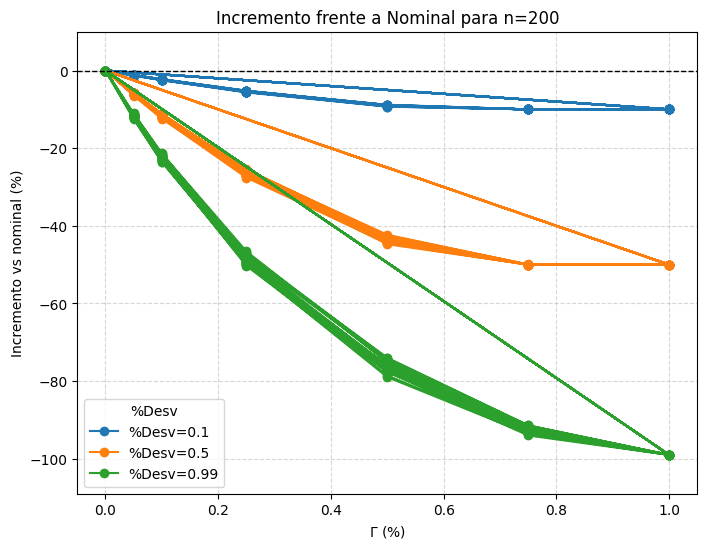

In [7]:
import matplotlib.pyplot as plt

# Fijar n
n_fijo = 200
df_plot = df_long_bs[df_long_bs["n"] == n_fijo].copy()
display(df_plot)

plt.figure(figsize=(8,6))

for desv, grupo in df_plot.groupby("%Desv"):
    plt.plot(grupo["%Gamma"], grupo["inc_vs_nominal"]*100,
             marker="o", label=f"%Desv={desv}")

plt.axhline(0, color="black", linewidth=1, linestyle="--")  # línea horizontal 0%

plt.xlabel(r"$\Gamma$ (%)")
plt.ylabel("Incremento vs nominal (%)")
plt.title(f"Incremento frente a Nominal para n={n_fijo}")
plt.legend(title="%Desv")
plt.grid(True, linestyle="--", alpha=0.5)

# Ajustar límites Y según datos
ymin = (df_plot["inc_vs_nominal"].min()*100) - 10
ymax = (df_plot["inc_vs_nominal"].max()*100) + 10
plt.ylim(ymin, ymax)

plt.show()


# estudio valor objetivo y tiempo

In [ ]:
import numpy as np
import pandas as pd

# Claves comunes
keys = ["Archivo", "n", "Capacidad", "%Desv"]

# Unimos objetivos SP y RO (Bertsimas–Sim)
wide_obj_all = wide_obj_bs.merge(wide_obj_sp, on=keys, how="inner")

# Columnas de métodos
cols_gamma = [c for c in wide_obj_all.columns if c.startswith("f_Gamma")]
cols_sp    = ["SP1", "SP2", "SP3", "SP4"]

# ========= 1) Incrementos % respecto a SP1 =========
baseline_sp = wide_obj_all["SP1"].astype(float)

# Métodos a comparar vs SP1: SP2..SP4 + todos los Gamma
cols_vs_sp = ["SP2", "SP3", "SP4"] + cols_gamma

def pct_inc(col_vals, base):
    col_vals = col_vals.astype(float)
    # Evitar división por 0: si base==0 -> NaN
    return np.where(base != 0.0, (col_vals - base) / base, np.nan)

wide_obj_vs_sp = wide_obj_all[keys].copy()
# SP1 como 0%
wide_obj_vs_sp["SP1"] = 0.0
# Resto respecto a SP1
for c in cols_vs_sp:
    wide_obj_vs_sp[c] = pct_inc(wide_obj_all[c], baseline_sp)

# (Opcional) orden de columnas
wide_obj_vs_sp = wide_obj_vs_sp[keys + cols_sp + cols_gamma]

# ========= 2) Incrementos % respecto a nominal (Gamma = 0%) =========
baseline_nom = wide_obj_all["f_Gamma0%"].astype(float)

# Métodos a comparar vs Γ=0%: SP1..SP4 + Gamma5..Gamma100 (dejamos Gamma0 como 0)
cols_vs_nom = cols_sp + [c for c in cols_gamma if c != "f_Gamma0%"]

wide_obj_vs_nom = wide_obj_all[keys].copy()
# Gamma0% como 0%
wide_obj_vs_nom["f_Gamma0%"] = 0.0
# Resto respecto a Gamma0%
for c in cols_vs_nom:
    wide_obj_vs_nom[c] = pct_inc(wide_obj_all[c], baseline_nom)

# (Opcional) orden de columnas: claves + SP + Gammas (Gamma0 primero)
wide_obj_vs_nom = wide_obj_vs_nom[keys + cols_sp + ["f_Gamma0%"] + [c for c in cols_gamma if c != "f_Gamma0%"]]

# (Opcional) redondeo
wide_obj_vs_sp  = wide_obj_vs_sp.round(6)
wide_obj_vs_nom = wide_obj_vs_nom.round(6)

# Vistas rápidas
print("=== Incrementos % respecto a SP1 ===")
display(wide_obj_vs_sp.head())
print("\n=== Incrementos % respecto a Γ=0% (nominal) ===")
display(wide_obj_vs_nom.head())


In [ ]:
wide_obj_vs_sp.to_excel("wide_obj_vs_sp.xlsx")
wide_obj_vs_nom.to_excel("wide_obj_vs_nom.xlsx")

files.download("wide_obj_vs_sp.xlsx")
files.download("wide_obj_vs_nom.xlsx")

In [ ]:
df_nom_agg = (
    wide_obj_vs_nom
    .groupby(["n"], as_index=False)      # Agrupa por n
    .mean(numeric_only=True)            # Calcula la media de TODAS las columnas numéricas
)
df_nom_agg.to_excel("df_nom_agg_SOLO_NUM_ITEMS.xlsx")
files.download("df_nom_agg_SOLO_NUM_ITEMS.xlsx")

In [ ]:
df_nom_agg_STD = (
    wide_obj_vs_nom
    .groupby(["n"], as_index=False)      # Agrupa por n
    .std(numeric_only=True)             # Calcula la desviación típica de TODAS las columnas numéricas
)

df_nom_agg_STD.to_excel("df_nom_agg_SOLO_NUM_ITEMS_STD.xlsx")
files.download("df_nom_agg_SOLO_NUM_ITEMS_STD.xlsx")

In [ ]:
df_agg_incertidumbre = (
    wide_obj_vs_nom
    .groupby(["n", "%Desv"], as_index=False)
    .mean(numeric_only=True)
)

df_agg_incertidumbre_STD = (
    wide_obj_vs_nom
    .groupby(["n", "%Desv"], as_index=False)
    .std(numeric_only=True)
)

df_agg_incertidumbre.to_excel("df_agg_incertidumbre.xlsx")
df_agg_incertidumbre_STD.to_excel("df_agg_incertidumbre_STD.xlsx")
files.download("df_agg_incertidumbre.xlsx")
files.download("df_agg_incertidumbre_STD.xlsx")

# estudio de tiempo de computación

In [ ]:
import numpy as np
import pandas as pd


wide_time = wide_time_bs.merge(
    wide_time_sp, on=["Archivo", "n", "Capacidad", "%Desv"],
    how="inner"
)
# --- Paso 1: Unir los dataframes (ya lo tienes) ---
# wide_time = wide_time_bs.merge(wide_time_sp, on=["Archivo", "n", "Capacidad", "%Desv"], how="inner")

# --- Paso 2: Seleccionar columnas de tiempo (mantenemos Archivo, n, %Desv) ---
cols_sp = ["tiempo_SP1", "tiempo_SP2", "tiempo_SP3", "tiempo_SP4"]
cols_bs = [c for c in wide_time.columns if c.startswith("tiempo_Gamma")]
cols_tiempo = cols_sp + cols_bs
base = wide_time[["Archivo", "n", "%Desv"] + cols_tiempo].copy()

# --- Paso 3: Formato largo conservando Archivo, n y %Desv ---
long_time = base.melt(
    id_vars=["Archivo", "n", "%Desv"],
    value_vars=cols_tiempo,
    var_name="Metodo",
    value_name="Tiempo"
)

# --- Paso 4: Promedio sobre %Desv por (Archivo, n, Metodo) ---
# (si hay varias filas para el mismo Archivo y n con %Desv=0.10/0.30/0.50, se promedia)
long_time_avg = (
    long_time
    .groupby(["Archivo", "n", "Metodo"], as_index=False)["Tiempo"]
    .mean()
)

# --- Paso 5: Estadísticos por (n, Metodo) usando las observaciones (Archivo) agregadas ---
def resumen(serie):
    med = serie.median()
    q1, q3 = np.percentile(serie, [25, 75])
    iqr = q3 - q1
    mean = serie.mean()
    std = serie.std(ddof=1)
    return pd.Series({
        "Median": med,
        "Median - IQR/2": med - iqr/2,
        "Median + IQR/2": med + iqr/2,
        "Mean": mean,
        "Mean - Std/2": mean - (std/2 if np.isfinite(std) else 0.0),
        "Mean + Std/2": mean + (std/2 if np.isfinite(std) else 0.0)
    })

df_stats_time = (
    long_time_avg
    .groupby(["n", "Metodo"])["Tiempo"]
    .apply(resumen)
    .reset_index()
)

# (Opcional) ordenar métodos: SP1..SP4 y luego Gamma ascendente
orden = ["tiempo_SP1","tiempo_SP2","tiempo_SP3","tiempo_SP4"] + sorted([c for c in cols_bs])
df_stats_time["Metodo"] = pd.Categorical(df_stats_time["Metodo"], categories=orden, ordered=True)
df_stats_time = df_stats_time.sort_values(["n","Metodo"]).reset_index(drop=True)

print(df_stats_time)


       n           Metodo         level_2    Tiempo
0     50       tiempo_SP1          Median  0.005933
1     50       tiempo_SP1  Median - IQR/2  0.003508
2     50       tiempo_SP1  Median + IQR/2  0.008358
3     50       tiempo_SP1            Mean  0.010131
4     50       tiempo_SP1    Mean - Std/2  0.004250
..   ...              ...             ...       ...
259  500  tiempo_Gamma75%  Median - IQR/2  0.006143
260  500  tiempo_Gamma75%  Median + IQR/2  0.006814
261  500  tiempo_Gamma75%            Mean  0.006667
262  500  tiempo_Gamma75%    Mean - Std/2  0.006276
263  500  tiempo_Gamma75%    Mean + Std/2  0.007057

[264 rows x 4 columns]


In [ ]:
import numpy as np
import pandas as pd

# --- 1) Unir (asumo que ya tienes wide_time_bs y wide_time_sp) ---
wide_time = wide_time_bs.merge(
    wide_time_sp, on=["Archivo", "n", "Capacidad", "%Desv"], how="inner"
)

# --- 2) Seleccionar columnas de tiempo y pasar a largo ---
cols_sp = ["tiempo_SP1", "tiempo_SP2", "tiempo_SP3", "tiempo_SP4"]
cols_bs = [c for c in wide_time.columns if c.startswith("tiempo_Gamma")]
cols_tiempo = cols_sp + cols_bs

long_time = wide_time.melt(
    id_vars=["Archivo", "n", "%Desv"],
    value_vars=cols_tiempo,
    var_name="Metodo",
    value_name="Tiempo"
)

# --- 3) Promediar sobre %Desv por (Archivo, n, Metodo) ---
long_time_avg = (
    long_time
    .groupby(["Archivo", "n", "Metodo"], as_index=False)["Tiempo"]
    .mean()
)

# --- 4) Estadísticos por (n, Metodo) ---
df_stats = (
    long_time_avg
    .groupby(["n", "Metodo"])["Tiempo"]
    .agg(
        Mediana="median",
        Q1=lambda x: np.percentile(x, 25),
        Q3=lambda x: np.percentile(x, 75),
        Media="mean",
        **{"Desv. típica": "std"}
    )
    .reset_index()
)

# --- Funciones auxiliares ---
def tabla_mediana(df, escala=1.0, dec=4, con_intervalo=False):
    df2 = df.copy()
    if con_intervalo:
        df2["Mediana [Q1, Q3]"] = df2.apply(
            lambda r: f"{r['Mediana']*escala:.{dec}f} [{r['Q1']*escala:.{dec}f}, {r['Q3']*escala:.{dec}f}]",
            axis=1
        )
        out = df2.pivot(index="n", columns="Metodo", values="Mediana [Q1, Q3]").reset_index()
    else:
        df2["Mediana"] = (df2["Mediana"]*escala).round(dec)
        out = df2.pivot(index="n", columns="Metodo", values="Mediana").reset_index()
    return out

def tabla_media(df, escala=1.0, dec=4, con_desv=False):
    df2 = df.copy()
    if con_desv:
        df2["Media ± Desv. típica"] = df2.apply(
            lambda r: f"{r['Media']*escala:.{dec}f} ± {r['Desv. típica']*escala:.{dec}f}",
            axis=1
        )
        out = df2.pivot(index="n", columns="Metodo", values="Media ± Desv. típica").reset_index()
    else:
        df2["Media"] = (df2["Media"]*escala).round(dec)
        out = df2.pivot(index="n", columns="Metodo", values="Media").reset_index()
    return out

# --- 5) Generar tablas ---
# (a) Mediana sola en ms
tabla_mediana_ms = tabla_mediana(df_stats, escala=1e3, dec=1, con_intervalo=False)

# (b) Media sola en segundos
tabla_media_s = tabla_media(df_stats, escala=1.0, dec=4, con_desv=False)

# (c) Mediana [Q1,Q3] en ms
tabla_mediana_iqr_ms = tabla_mediana(df_stats, escala=1e3, dec=1, con_intervalo=True)

# (d) Media ± Desv. típica en ms
tabla_media_desv_ms = tabla_media(df_stats, escala=1e3, dec=1, con_desv=True)

# (e) Media ± Desv. típica en segundos
tabla_media_desv_s = tabla_media(df_stats, escala=1.0, dec=4, con_desv=True)

# --- 6) Mostrar ---
display(tabla_mediana_ms)
display(tabla_media_s)
display(tabla_mediana_iqr_ms)
display(tabla_media_desv_ms)
display(tabla_media_desv_s)



Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,1.0,1.1,1.2,1.2,1.1,1.3,1.1,5.9,26.6,197.1,1463.3
1,100,1.8,2.0,2.4,2.2,1.8,2.4,2.6,7.6,43.7,340.2,3964.5
2,200,3.5,3.3,4.1,4.1,3.2,4.5,3.9,13.9,97.0,982.3,13842.0
3,500,3.9,6.0,6.2,7.9,4.9,9.1,6.5,30.8,292.3,4890.9,90811.1


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,0.0010,0.0012,0.0013,0.0012,0.0012,0.0015,0.0012,0.0101,0.0311,0.2140,1.6485
1,100,0.0018,0.0020,0.0023,0.0023,0.0020,0.0027,0.0026,0.0077,0.0439,0.3623,4.0359
2,200,0.0037,0.0037,0.0041,0.0041,0.0035,0.0050,0.0042,0.0143,0.1003,1.0343,13.9459
3,500,0.0043,0.0062,0.0064,0.0082,0.0051,0.0092,0.0067,0.0322,0.2986,4.9292,90.3874


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,"1.0 [0.9, 1.1]","1.1 [1.0, 1.2]","1.2 [1.1, 1.3]","1.2 [1.1, 1.3]","1.1 [1.0, 1.2]","1.3 [1.2, 1.5]","1.1 [1.1, 1.2]","5.9 [4.9, 9.8]","26.6 [25.4, 34.6]","197.1 [159.4, 243.0]","1463.3 [1275.4, 1936.2]"
1,100,"1.8 [1.6, 2.0]","2.0 [1.7, 2.1]","2.4 [2.1, 2.6]","2.2 [2.1, 2.5]","1.8 [1.7, 2.2]","2.4 [2.3, 2.8]","2.6 [2.1, 2.8]","7.6 [6.9, 8.6]","43.7 [38.8, 48.8]","340.2 [332.8, 390.0]","3964.5 [3701.3, 4307.0]"
2,200,"3.5 [2.9, 3.9]","3.3 [3.0, 4.0]","4.1 [3.7, 4.3]","4.1 [3.8, 4.2]","3.2 [2.9, 3.6]","4.5 [4.3, 5.3]","3.9 [3.7, 4.1]","13.9 [12.8, 15.8]","97.0 [83.5, 112.0]","982.3 [901.4, 1094.6]","13842.0 [13563.6, 14033.5]"
3,500,"3.9 [3.7, 4.2]","6.0 [5.5, 6.6]","6.2 [5.8, 6.9]","7.9 [7.0, 8.9]","4.9 [4.7, 5.3]","9.1 [8.7, 9.5]","6.5 [6.2, 6.9]","30.8 [29.9, 35.7]","292.3 [274.5, 317.5]","4890.9 [4858.8, 5104.0]","90811.1 [87859.3, 91133.8]"


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,1.0 ± 0.2,1.2 ± 0.4,1.3 ± 0.2,1.2 ± 0.2,1.2 ± 0.2,1.5 ± 0.5,1.2 ± 0.2,10.1 ± 11.8,31.1 ± 8.0,214.0 ± 58.5,1648.5 ± 453.1
1,100,1.8 ± 0.4,2.0 ± 0.5,2.3 ± 0.3,2.3 ± 0.4,2.0 ± 0.4,2.7 ± 0.8,2.6 ± 0.8,7.7 ± 1.0,43.9 ± 5.9,362.3 ± 45.3,4035.9 ± 420.3
2,200,3.7 ± 1.4,3.7 ± 1.0,4.1 ± 0.5,4.1 ± 0.8,3.5 ± 1.2,5.0 ± 1.1,4.2 ± 1.2,14.3 ± 1.8,100.3 ± 17.6,1034.3 ± 188.7,13945.9 ± 523.7
3,500,4.3 ± 1.4,6.2 ± 1.2,6.4 ± 0.8,8.2 ± 1.5,5.1 ± 0.6,9.2 ± 1.2,6.7 ± 0.8,32.2 ± 3.3,298.6 ± 34.7,4929.2 ± 260.8,90387.4 ± 4595.9


Metodo,n,tiempo_Gamma0%,tiempo_Gamma10%,tiempo_Gamma100%,tiempo_Gamma25%,tiempo_Gamma5%,tiempo_Gamma50%,tiempo_Gamma75%,tiempo_SP1,tiempo_SP2,tiempo_SP3,tiempo_SP4
0,50,0.0010 ± 0.0002,0.0012 ± 0.0004,0.0013 ± 0.0002,0.0012 ± 0.0002,0.0012 ± 0.0002,0.0015 ± 0.0005,0.0012 ± 0.0002,0.0101 ± 0.0118,0.0311 ± 0.0080,0.2140 ± 0.0585,1.6485 ± 0.4531
1,100,0.0018 ± 0.0004,0.0020 ± 0.0005,0.0023 ± 0.0003,0.0023 ± 0.0004,0.0020 ± 0.0004,0.0027 ± 0.0008,0.0026 ± 0.0008,0.0077 ± 0.0010,0.0439 ± 0.0059,0.3623 ± 0.0453,4.0359 ± 0.4203
2,200,0.0037 ± 0.0014,0.0037 ± 0.0010,0.0041 ± 0.0005,0.0041 ± 0.0008,0.0035 ± 0.0012,0.0050 ± 0.0011,0.0042 ± 0.0012,0.0143 ± 0.0018,0.1003 ± 0.0176,1.0343 ± 0.1887,13.9459 ± 0.5237
3,500,0.0043 ± 0.0014,0.0062 ± 0.0012,0.0064 ± 0.0008,0.0082 ± 0.0015,0.0051 ± 0.0006,0.0092 ± 0.0012,0.0067 ± 0.0008,0.0322 ± 0.0033,0.2986 ± 0.0347,4.9292 ± 0.2608,90.3874 ± 4.5959


In [ ]:
import pandas as pd
from google.colab import files

# Diccionario con nombre de hoja y DataFrame
tablas = {
    "Mediana_ms": tabla_mediana_ms,
    "Media_s": tabla_media_s,
    "Mediana_IQR_ms": tabla_mediana_iqr_ms,
    "Media_Desv_ms": tabla_media_desv_ms,
    "Media_Desv_s": tabla_media_desv_s,
}

# Guardar todas las tablas en un Excel con una hoja cada una
with pd.ExcelWriter("anexo_tablas.xlsx") as writer:
    for nombre, df in tablas.items():
        df.to_excel(writer, sheet_name=nombre, index=False)

# Descargar el archivo
files.download("anexo_tablas.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_stats_time_med.to_excel("df_stats_time_med.xlsx", index=False)
df_stats_time_mean.to_excel("df_stats_time_mean.xlsx", index=False)
files.download("df_stats_time_med.xlsx")
files.download("df_stats_time_mean.xlsx")

NameError: name 'df_stats_time_med' is not defined

In [ ]:
from google.colab import files

df_stats_time.to_excel("df_stats_time.xlsx", index=False)
files.download("df_stats_time.xlsx")
wide_time.to_excel("wide_time.xlsx", index=False)
files.download("wide_time.xlsx")

In [ ]:
from scipy.stats import shapiro
import pandas as pd

# Aplicamos test de Shapiro-Wilk por (n, Metodo)
def test_normalidad(grupo):
    stat, p = shapiro(grupo["Tiempo"])
    return pd.Series({
        "W-statistic": stat,
        "p-value": p,
        "Normal?": p > 0.05  # H0: los datos provienen de una dist. normal
    })

df_normalidad = long_time.groupby(["n", "Metodo"]).apply(test_normalidad).reset_index()

print(df_normalidad)


In [ ]:



for n, _ in wide_time.groupby("n")
cols_sp = ["tiempo_SP1", "tiempo_SP2", "tiempo_SP3", "tiempo_SP4"]
cols_bs = [c for c in wide_time.columns if c.startswith("tiempo_Gamma")]
cols = cols_sp + cols_bs

temp = wide_time[cols]
#display(temp)


long_time = temp.melt(var_name="Metodo", value_name="Tiempo")
#display(long_time)


# # --- Paso 4: Calcular estadísticas ---
def resumen(grupo):
    med = grupo.median()
    q1, q3 = grupo.quantile([0.25, 0.75])
    iqr = q3 - q1
    mean = grupo.mean()
    std = grupo.std()
    return pd.Series({
        "Median": med,
        "Median - IQR/2": med - iqr/2,
        "Median + IQR/2": med + iqr/2,
        "Mean": mean,
        "Mean - Std/2": mean - std/2,
        "Mean + Std/2": mean + std/2
    })

df_stats_time = long_time.groupby("Metodo")["Tiempo"].apply(resumen).reset_index()

print(df_stats_time)


In [ ]:
display(df_stats_time)

# ARCHIVED

In [ ]:
# --- Guardar a Excel (dos hojas) y descargar si estás en Colab ---
# out_name = "Resultados_SP1_SP4_n50_100_200.xlsx"
# with pd.ExcelWriter(out_name, engine="xlsxwriter") as writer:
#     df_res.to_excel(writer, sheet_name="long", index=False)
#     wide_sp.to_excel(writer, sheet_name="wide", index=False)

# if IN_COLAB:
#     files.download(out_name)
# else:
#     print(f"\n[Info] Archivo guardado: {out_name} (ejecuta en Colab para descargar automáticamente).")

# # --- Guardar a Excel (dos hojas) y descargar si estás en Colab ---
# out_name = "Resultados_SP1_SP4_n50_100_200.xlsx"
# with pd.ExcelWriter(out_name, engine="xlsxwriter") as writer:
#     df_res.to_excel(writer, sheet_name="long", index=False)
#     wide_sp.to_excel(writer, sheet_name="wide", index=False)

# if IN_COLAB:
#     files.download(out_name)
# else:
#     print(f"\n[Info] Archivo guardado: {out_name} (ejecuta en Colab para descargar automáticamente).")






# import numpy as np
# # PRUEBAS CON SOLO 1 INSTANCIA
# # --- Selecciona una instancia de df_kplib ---
# i = 6  # <-- cambia el indice si quieres otra fila
# u   = df_kplib.at[i, "Utilidades"]
# w   = df_kplib.at[i, "Pesos"]
# cap = float(df_kplib.at[i, "Capacidad"])
# arc = df_kplib.at[i, "Archivo"] if "Archivo" in df_kplib.columns else f"idx_{i}"

# bar_c, pesos = np.array(u, float), np.array(w, float)
# assert bar_c.size == pesos.size, "Utilidades y pesos deben tener la misma longitud"

# # --- Parametros de incertidumbre y muestreo ---
# pct_desviacion, seed, n_smpl = 0.50, 123, 8  # ajusta si quieres

# print(f"Instancia: {arc} | n={bar_c.size} | cap={cap} | pct={pct_desviacion} | n_smpl={n_smpl} | seed={seed}")

# for t in (1, 2, 3, 4):
#     print("\n" + "-"*60)
#     print(f"Resolviendo SP{t} ...")
#     sol = solve_sp(bar_c, pesos, cap, pct_desviacion, t=t, n_smpl=n_smpl, seed=seed, verbose=True)
#     print(f"Resumen SP{t}: status={sol['status']} | obj={sol['objective']:.4f} | vars={sol['n_vars']} | cons={sol['n_constrs']}")